# Cannabis Clustering
The main goal of this should be to compare the DBSCAN clustering algorithm (non-linear) to another clusering algorithm (e.g. K-means Clustering which is Linear).

1. Run the hidden cells in Part I & Part II. This will import and clean the data before performing dimensionality reduction. The PCA plot isn't great for visualization, but it tells us that the data is high-dimensional but linear (can be fully separated into 18 Principal Components-- AKA 18-Dimensional but linear). For the most part, I used the UMAP reduction for plotting. You can plot things by calling *sns.scatter()* and set: 



> **x=clean_lowD_60[:, 0]**

>**y=clean_lowD_60[:, 1]**.

2. Run DBSCAN with the parameters kept as they are. These are the parameters we used for our clustering with DBSCAN, so you should be able to compare the results you got with linear clustering (k-means) to these clusters.
3. Run the linear clustering algorithm. 

4. Once you have the clusters with different values for the linear clustering algorithm's hyperparmaters, you can compare the clusters based on extant data on cannabis types (happy to talk more about this with you).


In [1]:
# Import essential packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
#import gspread
#from gspread_dataframe import get_as_dataframe, set_with_dataframe 

In [2]:
#@title Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Part I: Import the Data

## Step 1
In this first chunk of code, we read a dataframe from the data csv found on github. Once this has been loaded, we remove any columns not needed for this analysis.We next normalize the cannabinoid and terpene data separately. To do this, we divide each set by the value of its largest element. As a result, we are left with a data entry comprised of a *strain name*, *region*, *cannabinoid profile*, and *terpene profile*.

Lastly, some of the entries are missing data. Since the data set is so large, we drop entries with missing data.

Once we have this cleaned data set, it can be further separated into smaller data sets based on where each strain was grown. Using this method, we create four regional sub-sets. This gives us:

1. **clean_data** (Full data set)
2. **AK_data** (Arkansas data set)
3. **OR_data** (Oregon data set)
4. **WA_data** (Washington data set)
5. **CA_data** (California data set)

Each of these data sets is now ready to be reduced to a lower dimensional space using PCA or UMAP in (Part II). **{Ready}**

In Part III, we'll use a clustering algorithm like DBSCAN to categorize cannabis based on the results in Part II. **{Read minus plots}**

In Part IV, we'll generate a data set that includes cluster membership for each entry. This data set will be randomly split into a test set and a training set.**{Ready}**

In Part V, we'll train a LASSO regression model on the training data until it can accurately assign categories for each entry.

In Part VI, we'll test the LASSO regression model on the test set and get the classification error rate.
 
Depending on our success here, we can move onto an optional Part VII where we classify strains not originally in the data set using freely available COAs.

In [30]:
#@title Load in data as CSV
data_url = "https://raw.githubusercontent.com/cjsmith015/phytochemical-diversity-cannabis/main/data/preproc_lab_data_pub_20220218.csv"
raw_data = pd.read_csv(data_url, index_col=0)
df = raw_data.drop(columns = ['lab_id', 'anon_producer', 'product_category', 'strain_category', 
                              'strain_popularity', 'chemotype', 'has_cannabs', 'has_terps', 'terp_var',
                              'chemotype_ratio','total_terps', 'top_terp_f'])
df.head()

,strain_slug,region,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,...,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,AK,20.103098,0.047210,1.097430,0.000000,0.0,0.255775,0.251212,0.01,...,0.217018,0.560682,0.159195,0.032776,0.177072,0.029597,0.114252,0.010000,0.321310,0.075442
1,NaN,AK,17.775078,0.085711,0.904467,0.046734,0.0,0.050000,0.374661,0.01,...,0.143383,0.315326,0.127196,0.010000,0.199761,0.010000,0.069859,0.012731,0.365565,0.060920
2,NaN,AK,18.196924,0.079075,0.923358,0.056123,0.0,0.050000,0.334714,0.01,...,0.140367,0.306051,0.111072,0.022061,0.177568,0.010000,0.057884,0.011981,0.336826,0.049393
3,NaN,AK,19.302718,0.059964,0.517679,0.034465,0.0,0.050000,0.010000,0.01,...,0.167629,0.385306,0.134872,0.056048,0.368547,0.048849,0.035711,0.000000,0.000000,0.020058
4,NaN,AK,18.224250,0.071973,0.966903,0.000000,0.0,0.231606,0.158674,0.01,...,0.127600,0.317787,0.116072,0.029350,0.099418,0.010000,0.083642,0.010000,0.179980,0.056437


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89923 entries, 0 to 89922
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   strain_slug       73414 non-null  object 
 1   region            89923 non-null  object 
 2   tot_thc           89854 non-null  float64
 3   tot_cbd           47205 non-null  float64
 4   tot_cbg           83251 non-null  float64
 5   tot_cbc           59545 non-null  float64
 6   tot_cbn           51993 non-null  float64
 7   tot_thcv          35682 non-null  float64
 8   tot_ocimene       85994 non-null  float64
 9   camphene          42767 non-null  float64
 10  g_terpinene       39148 non-null  float64
 11  tot_nerolidol_ct  85994 non-null  float64
 12  humulene          42913 non-null  float64
 13  caryophyllene     43145 non-null  float64
 14  limonene          43021 non-null  float64
 15  linalool          42974 non-null  float64
 16  myrcene           43144 non-null  float6

In [32]:
df.describe()

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
count,89854.000000,47205.000000,83251.000000,59545.000000,51993.000000,35682.000000,85994.000000,42767.000000,39148.000000,85994.000000,42913.000000,43145.000000,43021.000000,42974.000000,43144.000000,36500.000000,40312.000000,41934.000000,43047.000000,43143.000000
mean,18.051735,0.776794,0.766569,0.051537,0.021568,0.059726,0.027520,0.015886,0.007971,0.030940,0.117040,0.328473,0.273622,0.102338,0.469627,0.043923,0.090410,0.011561,0.099082,0.119702
std,4.954737,2.746992,0.573832,0.242936,0.055090,0.195025,0.091359,0.036270,0.025524,0.097256,0.088657,0.239185,0.231063,0.111005,0.432755,0.051982,0.065202,0.060127,0.267692,0.174712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.479765,0.038079,0.373007,0.000000,0.000000,0.000000,0.000000,0.007000,0.000000,0.000000,0.058290,0.161000,0.098000,0.039822,0.168200,0.010000,0.050000,0.000000,0.000000,0.031559
50%,18.292625,0.057005,0.628743,0.030000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.097000,0.270000,0.210000,0.075183,0.340000,0.030000,0.079000,0.000000,0.010000,0.058359
75%,21.102280,0.100000,0.999460,0.068700,0.025480,0.053000,0.010000,0.023373,0.010000,0.013000,0.155000,0.435661,0.394400,0.136000,0.639800,0.060000,0.114588,0.010000,0.029035,0.125826
max,35.679320,36.652970,17.636318,30.000000,1.974000,16.400000,2.320000,4.000000,1.410000,2.130000,1.109020,3.826735,3.326854,3.740000,4.523000,1.960000,1.021581,2.290000,3.006461,4.005000


In [40]:
flag = pd.isnull(df["strain_slug"])
df.loc[flag, "strain_slug"] = "Sample_" + df.index[flag].astype(str)
df

,strain_slug,region,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,...,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,,
0,Sample_0,AK,20.103098,0.047210,1.097430,0.000000,0.000,0.255775,0.251212,0.01,...,0.217018,0.560682,0.159195,0.032776,0.177072,0.029597,0.114252,0.010000,0.321310,0.075442
1,Sample_1,AK,17.775078,0.085711,0.904467,0.046734,0.000,0.050000,0.374661,0.01,...,0.143383,0.315326,0.127196,0.010000,0.199761,0.010000,0.069859,0.012731,0.365565,0.060920
2,Sample_2,AK,18.196924,0.079075,0.923358,0.056123,0.000,0.050000,0.334714,0.01,...,0.140367,0.306051,0.111072,0.022061,0.177568,0.010000,0.057884,0.011981,0.336826,0.049393
3,Sample_3,AK,19.302718,0.059964,0.517679,0.034465,0.000,0.050000,0.010000,0.01,...,0.167629,0.385306,0.134872,0.056048,0.368547,0.048849,0.035711,0.000000,0.000000,0.020058
4,Sample_4,AK,18.224250,0.071973,0.966903,0.000000,0.000,0.231606,0.158674,0.01,...,0.127600,0.317787,0.116072,0.029350,0.099418,0.010000,0.083642,0.010000,0.179980,0.056437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89918,cereal-milk,CA,17.619045,NaN,0.306790,0.001000,0.001,NaN,0.000000,NaN,...,0.072000,0.229000,0.166000,0.070000,0.130000,0.040000,0.030000,NaN,NaN,0.015000
89919,pink-kush,CA,24.009297,NaN,0.562350,0.001000,NaN,NaN,0.000000,NaN,...,0.094000,0.315000,0.304000,0.100000,0.240000,0.110000,0.050000,NaN,NaN,0.030000
89920,pink-kush,CA,24.026490,NaN,1.162400,0.001000,NaN,NaN,0.000000,NaN,...,0.079000,0.215000,0.313000,0.120000,0.030000,0.020000,0.050000,NaN,NaN,0.033000


In [ ]:
#@title Normalize Cannabinoids
CB_raw = selected_data.iloc[:, 2:8]
CB_norm = CB_raw
for row in range(len(CB_raw)):
  CB_norm.iloc[row] = CB_raw.iloc[row] / sum(CB_raw.iloc[row])
CB_norm.head()

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv
u_id,,,,,,
0,0.934875,0.002195,0.051035,0.000000,0.0,0.011895
1,0.942376,0.004544,0.047952,0.002478,0.0,0.002651
2,0.942578,0.004096,0.047829,0.002907,0.0,0.002590
3,0.966836,0.003003,0.025930,0.001726,0.0,0.002504
4,0.934829,0.003692,0.049598,0.000000,0.0,0.011880


In [ ]:
#@title Normalize Terpenes
TP_raw = selected_data.iloc[:, 8:]
TP_norm = TP_raw
for row in range(len(TP_raw)):
  TP_norm.iloc[row] = TP_raw.iloc[row] / sum(TP_raw.iloc[row])

TP_norm.head()

,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,
0,0.126627,0.005041,0.007724,0.005041,0.109391,0.282619,0.080244,0.016521,0.089255,0.014919,0.057590,0.005041,0.161961,0.038028
1,0.215732,0.005758,0.008682,0.012792,0.082561,0.181566,0.073240,0.005758,0.115024,0.005758,0.040225,0.007331,0.210494,0.035078
2,0.208189,0.006220,0.008142,0.016626,0.087307,0.190361,0.069086,0.013722,0.110446,0.006220,0.036003,0.007452,0.209503,0.030722
3,0.008019,0.008019,0.008019,0.000000,0.134423,0.308981,0.108156,0.044945,0.295542,0.039173,0.028637,0.000000,0.000000,0.016085
4,0.129744,0.008177,0.011458,0.008177,0.104336,0.259848,0.094910,0.023999,0.081292,0.008177,0.068392,0.008177,0.147166,0.046147


In [ ]:
#@title Recombine Normalized Data into Clean Data set
indentifiers = selected_data.iloc[:, 0:2]
clean_data = pd.concat([indentifiers, CB_norm, TP_norm], axis=1)
clean_data = clean_data.dropna()
clean_data

,strain_slug,region,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,...,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,,
0,Sample_0,AK,0.934875,0.002195,0.051035,0.000000,0.0,0.011895,0.126627,0.005041,...,0.109391,0.282619,0.080244,0.016521,0.089255,0.014919,0.057590,0.005041,0.161961,0.038028
1,Sample_1,AK,0.942376,0.004544,0.047952,0.002478,0.0,0.002651,0.215732,0.005758,...,0.082561,0.181566,0.073240,0.005758,0.115024,0.005758,0.040225,0.007331,0.210494,0.035078
2,Sample_2,AK,0.942578,0.004096,0.047829,0.002907,0.0,0.002590,0.208189,0.006220,...,0.087307,0.190361,0.069086,0.013722,0.110446,0.006220,0.036003,0.007452,0.209503,0.030722
3,Sample_3,AK,0.966836,0.003003,0.025930,0.001726,0.0,0.002504,0.008019,0.008019,...,0.134423,0.308981,0.108156,0.044945,0.295542,0.039173,0.028637,0.000000,0.000000,0.016085
4,Sample_4,AK,0.934829,0.003692,0.049598,0.000000,0.0,0.011880,0.129744,0.008177,...,0.104336,0.259848,0.094910,0.023999,0.081292,0.008177,0.068392,0.008177,0.147166,0.046147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88943,Sample_88943,CA,0.938651,0.002171,0.059177,0.000000,0.0,0.000000,0.000000,0.002157,...,0.092752,0.290768,0.195427,0.060828,0.251079,0.029767,0.029336,0.000000,0.000000,0.017256
88944,Sample_88944,CA,0.950399,0.002075,0.047527,0.000000,0.0,0.000000,0.000000,0.006301,...,0.069307,0.221872,0.257426,0.109811,0.207921,0.029253,0.044104,0.000000,0.008101,0.025653
88980,gods-gift,CA,0.969916,0.002917,0.026502,0.000665,0.0,0.000000,0.059835,0.002063,...,0.091472,0.191197,0.046080,0.020633,0.366575,0.038514,0.045392,0.000000,0.000000,0.097662


# Part II: Dimensionality Reduction

Now that we have the data cleaned, we can use dimensionality reduction techniques to learn more about the high-dimensional relationships between samples.

First, we can use PCA to get a sense of how high-dimensional the data is. The code below will run PCA on the data for 10 components by default. For some subsets of the data, these components explain upwards of 85% of the variance. While this is a good position to be in, it's clear that there is something nonlinear going on.

Clustering is typically done with PCA because of the way that clustering algorithms tend to define distance. However, since PCA is better for linear relationships, it's worth investigating an alternative approach.

The good candidate to use on nonlinear data is UMAP. That said, UMAP has several parameters that can be adjusted to capture more local or global features, so we should play with a few values of these parameters to better analyze the data.

In Part III, we'll use a clustering algorithm like OPTICS or DBSCAN to categorize cannabis based on the results in Part II.

So far it seems like we should be expecting approximately 3-10 clusters based on initial results from PCA and UMAP.

In [ ]:
#@title PCA Code
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#@title Full PCA
scaler = StandardScaler()
clean_data_values = clean_data.iloc[:, 2:]
clean_data_values.head()
clean_data_scaled = scaler.fit_transform(clean_data_values)

pca = PCA(n_components=19)
clean_data_pca = pca.fit(clean_data_scaled)
clean_vectors = clean_data_pca.components_
clean_explained = clean_data_pca.explained_variance_ratio_
clean_data_pcs = clean_data_pca.transform(clean_data_scaled)
print("Total variance explained by the first 19 principal componets is "+ 
      str(sum(clean_explained)) + "%" +
      ". Each PC in order explains this much variance " +
      str(clean_explained))

clean_data_pc_values = pd.DataFrame(data = clean_data_pcs[:,0:3], columns = ['PC1', 'PC2', 'PC3'])

identifiers = clean_data.iloc[:, 0:2]

#clean_data_pcs = pd.concat([identifiers, clean_data_pc_values], axis=1)
clean_data_pc_values.head()

#print(clean_data_pc_values.shape, identifiers.shape)

Total variance explained by the first 19 principal componets is 1.0000000000000002%. Each PC in order explains this much variance [1.45556015e-01 1.08788994e-01 1.03615324e-01 8.68494019e-02
 7.06429041e-02 6.62296585e-02 5.94339438e-02 5.49354589e-02
 4.93280332e-02 3.94389855e-02 3.78204834e-02 3.57697973e-02
 3.53755644e-02 3.08423252e-02 2.68253226e-02 2.40248744e-02
 1.47658940e-02 9.75701979e-03 1.28921308e-32]


,PC1,PC2,PC3
0,0.062433,-0.460243,-0.603420
1,1.031236,-0.540904,0.058997
2,0.826590,-0.463258,0.082797
3,-1.583976,0.310109,-0.703823
4,0.289402,-0.635416,-0.417411


In [ ]:
#@title Plot 1st Two PCs redacted
#fig = plt.figure()

#sns.set(style = "white")

#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(clean_data_pcs.iloc[:, 2], clean_data_pcs.iloc[:, 3], clean_data_pcs.iloc[:,4], label=regions, cmap='Set1')
#ax.set_title('Full Data 1st two PCs')
#ax.set_xlabel('PC1')
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')
#ax.legend()
#plt.show()

##plt.title('First two principal components of Chemical Data')

All variance is explained by the first 19 PCs


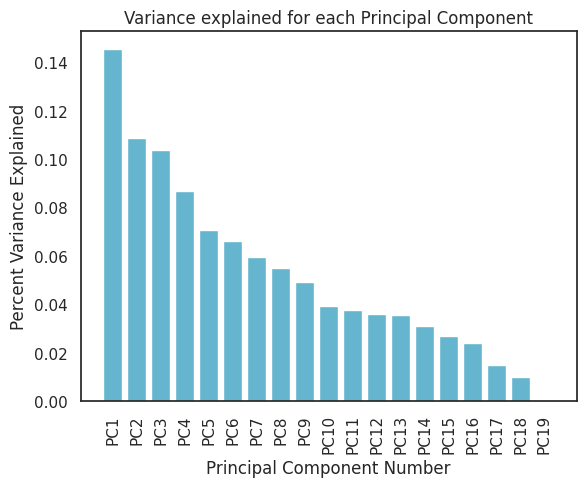

In [ ]:
#@title A Closer Look at Explained Variance
plt.bar(x = ['PC1','PC2', 'PC3','PC4', 'PC5',
             'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
             'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
             'PC16', 'PC17', 'PC18', 'PC19'], height = clean_explained, color='c')
plt.title('Variance explained for each Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Percent Variance Explained')
plt.xticks(rotation=90)
print('All variance is explained by the first 19 PCs')

In [ ]:
#@title Install UMAP
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title UMAP Preparatory Code
import umap

In [ ]:
#@title Plotting Functions
!pip install bokeh
import holoviews
import colorcet
import skimage
!pip install datashader
import datashader as ds
import umap.plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Full Data Set UMAP
clean_data_umap = umap.UMAP(random_state=420, n_neighbors=15, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_15 = clean_data_umap.fit_transform(scaled_clean_data)

clean_data_umap = umap.UMAP(random_state=420, n_neighbors=10, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_10 = clean_data_umap.fit_transform(scaled_clean_data)

clean_data_umap = umap.UMAP(random_state=420, n_neighbors=45, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_45 = clean_data_umap.fit_transform(scaled_clean_data)

clean_data_umap = umap.UMAP(random_state=420, n_neighbors=60, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_60 = clean_data_umap.fit_transform(scaled_clean_data)


Text(0.5, 0.98, 'UMAP Reveals Local and Global Structure with Choice of n_neighbors Parameter')

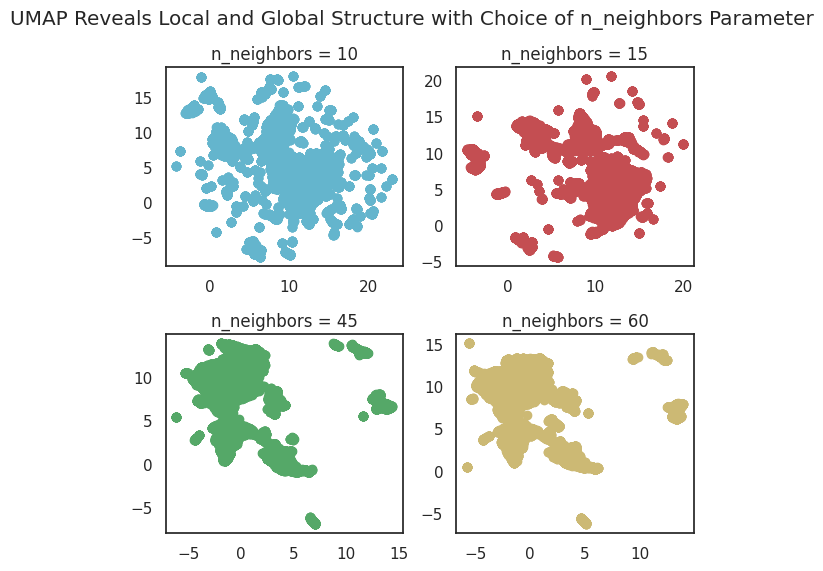

In [ ]:

fig, axs = plt.subplots(2,2, figsize=(6,6))
axs[0,0].scatter(clean_lowD_10[:,0], clean_lowD_10[:,1], color='c')
axs[0,0].set_title('n_neighbors = 10')
axs[0,1].scatter(clean_lowD_15[:,0], clean_lowD_15[:,1], color='r')
axs[0,1].set_title('n_neighbors = 15')
axs[1,0].scatter(clean_lowD_45[:,0], clean_lowD_45[:,1], color='g')
axs[1,0].set_title('n_neighbors = 45')
axs[1,1].scatter(clean_lowD_60[:,0], clean_lowD_60[:,1], color='y')
axs[1,1].set_title('n_neighbors = 60')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('UMAP Reveals Local and Global Structure with Choice of n_neighbors Parameter')
#plt.scatter(clean_lowD[:,0], clean_lowD[:,1])
#plt.title('UMAP for Full Data Set')

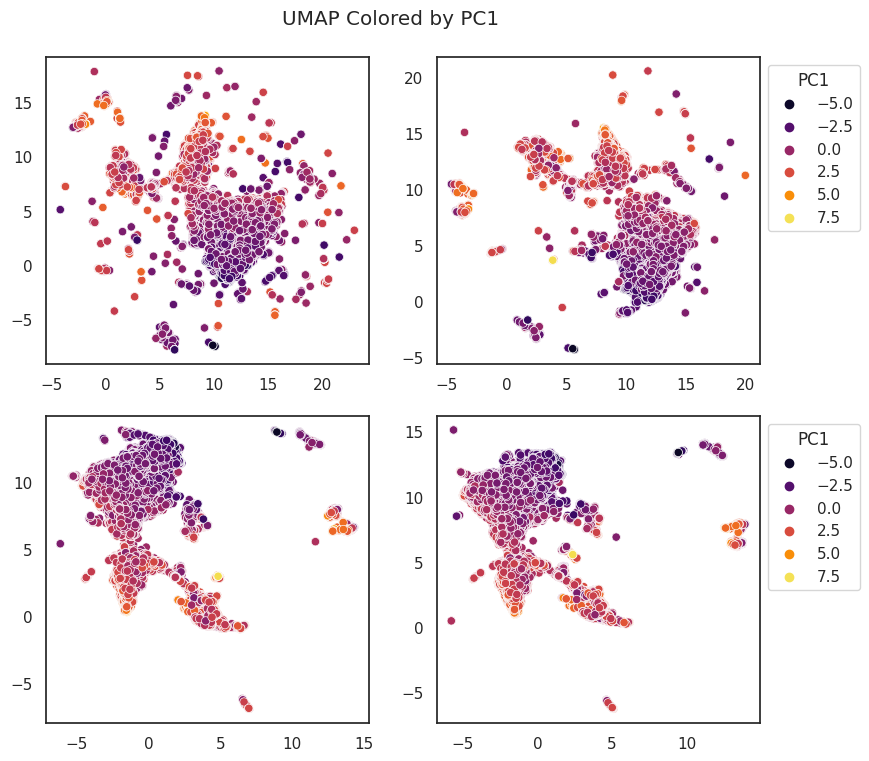

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('UMAP Colored by PC1')

sns.scatterplot(ax = axes[0,0], x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data_pc_values, hue='PC1', palette='inferno', legend=False)
sns.scatterplot(ax = axes[0,1], x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data_pc_values, hue='PC1', palette='inferno')
sns.scatterplot(ax = axes[1,0], x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data_pc_values, hue='PC1', palette='inferno', legend=False)
sns.scatterplot(ax = axes[1,1], x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data_pc_values, hue='PC1', palette='inferno')


sns.move_legend(axes[0,1], "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(axes[1,1], "upper left", bbox_to_anchor=(1, 1))

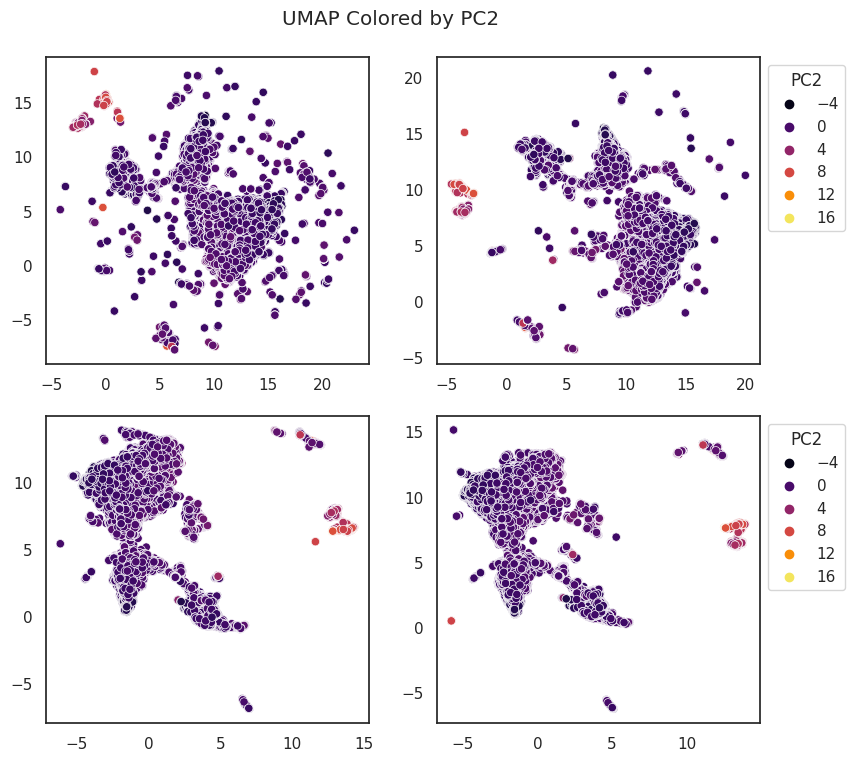

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('UMAP Colored by PC2')

sns.scatterplot(ax = axes[0,0], x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data_pc_values, hue='PC2', palette='inferno', legend=False)
sns.scatterplot(ax = axes[0,1], x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data_pc_values, hue='PC2', palette='inferno')
sns.scatterplot(ax = axes[1,0], x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data_pc_values, hue='PC2', palette='inferno', legend=False)
sns.scatterplot(ax = axes[1,1], x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data_pc_values, hue='PC2', palette='inferno')


sns.move_legend(axes[0,1], "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(axes[1,1], "upper left", bbox_to_anchor=(1, 1))

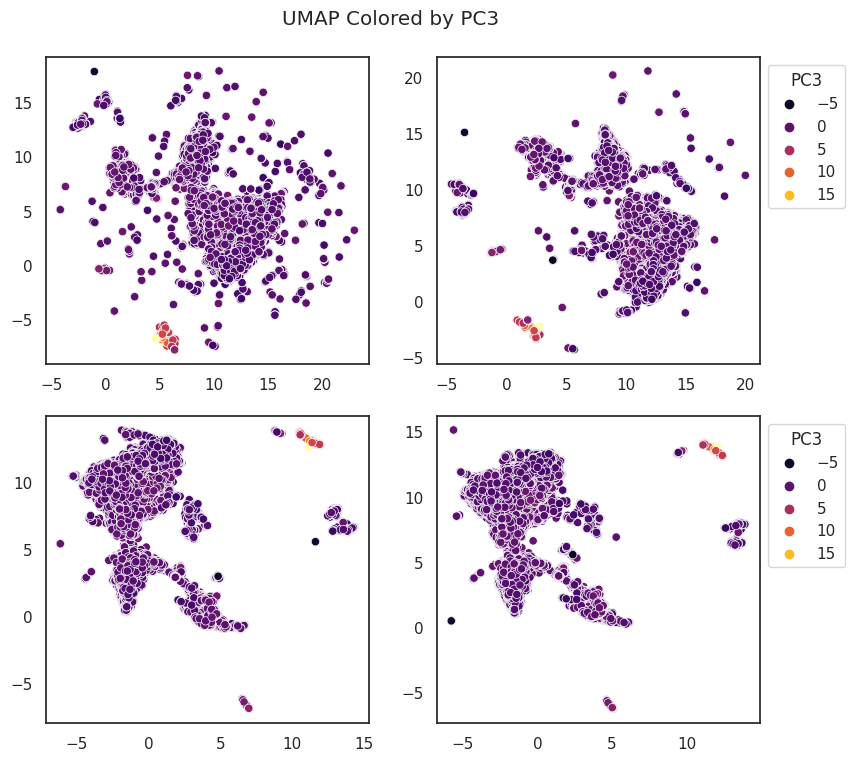

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('UMAP Colored by PC3')

sns.scatterplot(ax = axes[0,0], x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data_pc_values, hue='PC3', palette='inferno', legend=False)
sns.scatterplot(ax = axes[0,1], x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data_pc_values, hue='PC3', palette='inferno')
sns.scatterplot(ax = axes[1,0], x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data_pc_values, hue='PC3', palette='inferno', legend=False)
sns.scatterplot(ax = axes[1,1], x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data_pc_values, hue='PC3', palette='inferno')


sns.move_legend(axes[0,1], "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(axes[1,1], "upper left", bbox_to_anchor=(1, 1))

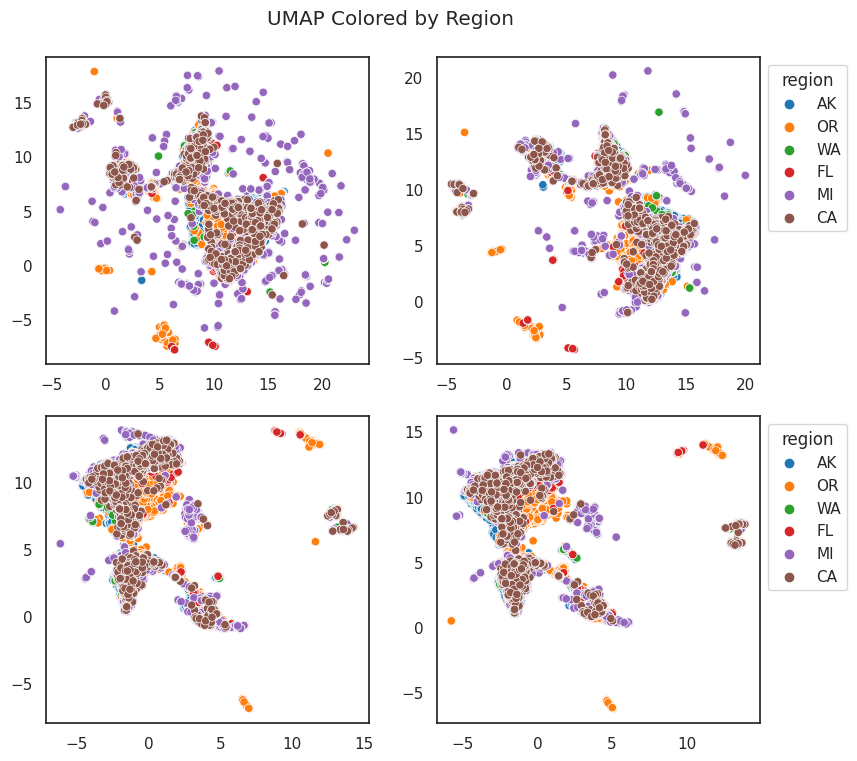

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('UMAP Colored by Region')

sns.scatterplot(ax = axes[0,0], x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data, hue='region', palette='tab10', legend=False)
sns.scatterplot(ax = axes[0,1], x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data, hue='region', palette='tab10')
sns.scatterplot(ax = axes[1,0], x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data, hue='region', palette='tab10', legend=False)
sns.scatterplot(ax = axes[1,1], x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data, hue='region', palette='tab10')


sns.move_legend(axes[0,1], "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(axes[1,1], "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'UMAP with 10 Neighbors')

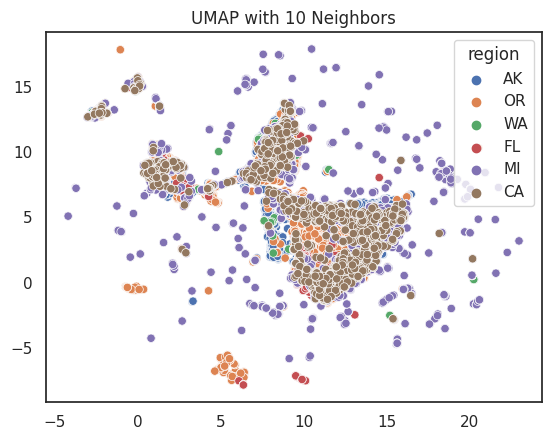

In [ ]:
#@title Regional Breakdown 1
sns.scatterplot(x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data, hue='region')
plt.title('UMAP with 10 Neighbors')

Text(0.5, 1.0, 'UMAP with 15 Neighbors')

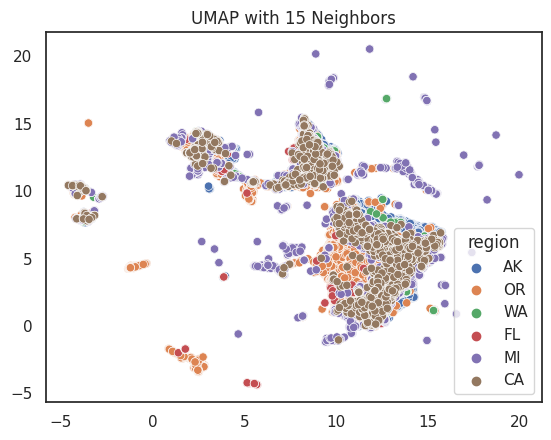

In [ ]:
#@title Regional Breakdown 2
sns.scatterplot(x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data, hue='region')
plt.title('UMAP with 15 Neighbors')

Text(0.5, 1.0, 'UMAP with 45 Neighbors')

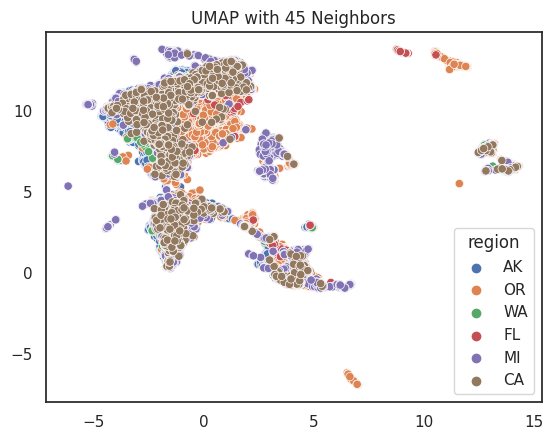

In [ ]:
#@title Regional Breakdown 3
sns.scatterplot(x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data, hue='region')
plt.title('UMAP with 45 Neighbors')

Text(0.5, 1.0, 'UMAP with 60 Neighbors')

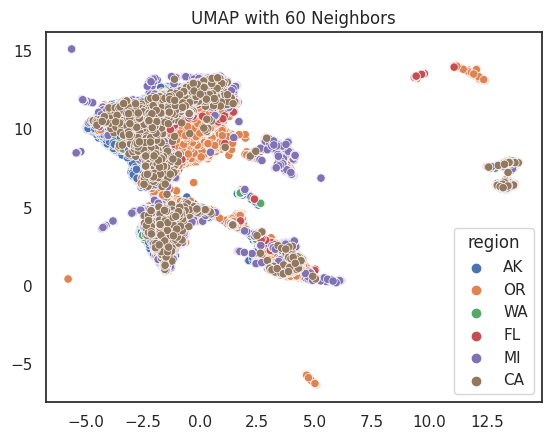

In [ ]:
#@title Regional Breakdown 4
sns.scatterplot(x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data, hue='region')
plt.title('UMAP with 60 Neighbors')

In [ ]:
max_terp_data = clean_data.iloc[:,8:-2]
max_terp_data['max_terp']= clean_data.iloc[:,8:-2].idxmax(axis=1)
max_terp_data

,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,max_terp
u_id,,,,,,,,,,,,,
0,0.126627,0.005041,0.007724,0.005041,0.109391,0.282619,0.080244,0.016521,0.089255,0.014919,0.057590,0.005041,caryophyllene
1,0.215732,0.005758,0.008682,0.012792,0.082561,0.181566,0.073240,0.005758,0.115024,0.005758,0.040225,0.007331,tot_ocimene
2,0.208189,0.006220,0.008142,0.016626,0.087307,0.190361,0.069086,0.013722,0.110446,0.006220,0.036003,0.007452,tot_ocimene
3,0.008019,0.008019,0.008019,0.000000,0.134423,0.308981,0.108156,0.044945,0.295542,0.039173,0.028637,0.000000,caryophyllene
4,0.129744,0.008177,0.011458,0.008177,0.104336,0.259848,0.094910,0.023999,0.081292,0.008177,0.068392,0.008177,caryophyllene
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88943,0.000000,0.002157,0.000000,0.030630,0.092752,0.290768,0.195427,0.060828,0.251079,0.029767,0.029336,0.000000,caryophyllene
88944,0.000000,0.006301,0.000000,0.020252,0.069307,0.221872,0.257426,0.109811,0.207921,0.029253,0.044104,0.000000,limonene
88980,0.059835,0.002063,0.000000,0.040578,0.091472,0.191197,0.046080,0.020633,0.366575,0.038514,0.045392,0.000000,myrcene


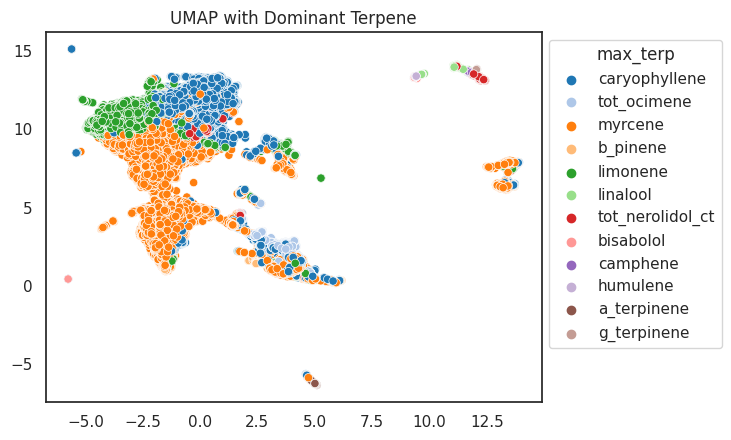

In [ ]:
#@title Terpene Breakdown
ax = sns.scatterplot(x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=max_terp_data, hue='max_terp', palette='tab20')
plt.title('UMAP with Dominant Terpene')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#Part III: Clustering Analysis

Based on what I've read and watched, the primary clustering method should be DBSCAN. Like UMAP, there are some hyperparameters we can set that will affect cluster size/ noise assignment. The cool thing about DBSCAN is that it doesn't assign all of the points to a cluster, so when we eventually fit a regression model, we can try to predict cluster membership of the outlier strains.

I'm looking for a package that can do K-medoids too. It's like K-means, so that's a back-up for what I'm thinking for this second clustering analysis. One cool thing we could do if we have time for is to use K-medoids/K-means to separate the data in 3 clusters and see how well (poorly) Sativa/Hybrid/Indica labels predict a strains membership in one of the clusters. I think we can save this for later though.

In later parts, we'll use these clusters to fit linear models. I've realized that even this step has two potential approaches. 

1) We use an L2-norm penalty (Ridge Regression) which can be used for future classification problems or 

2) We use an L1-norm penalty (Lasso Regression) which can be used to make inferences about important features

Both approaches are valuable-- we can think about this more when we get to that step

In [ ]:
#@title Implement DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

In [ ]:
#@title Import Knee Finder
!pip install kneed

from kneed import KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[5.336952518250275]


Text(0.5, 1.0, 'Nearest Neighbor Plot for Full Dataset')

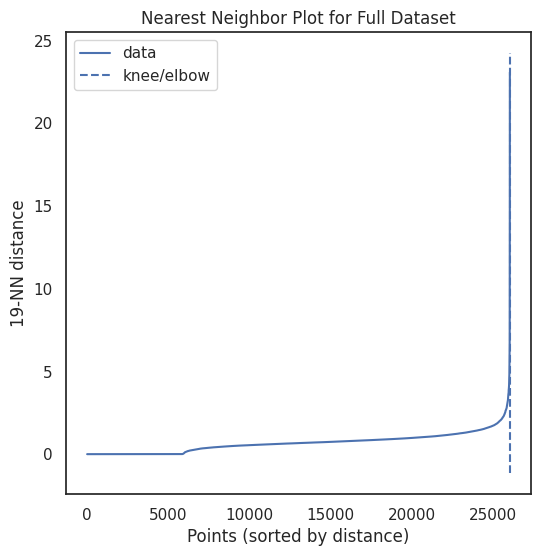

In [ ]:
#@title Estimate Epsilon for DBSCAN
clean_data_values_db = clean_data.iloc[:, 2:]
scaler = StandardScaler()
scaled_clean_data_values_db = scaler.fit_transform(clean_data_values_db)

	
neighbors = NearestNeighbors(n_neighbors=19)
neighbors_fit = neighbors.fit(scaled_clean_data_values_db)
distances, indices = neighbors_fit.kneighbors(scaled_clean_data_values_db)


distances = np.sort(distances, axis=0)
distances = distances[:,1]
sort_index = np.arange(len(distances))
kl = KneeLocator(sort_index, distances, curve="convex")

print(kl.all_knees_y)

#eps_line = eps_val * np.ones(len(distances))

#plt.plot(eps_line)
#plt.plot(distances)
KneeLocator.plot_knee(kl)
plt.xlabel('Points (sorted by distance)')
plt.ylabel('19-NN distance')
plt.title('Nearest Neighbor Plot for Full Dataset')

In [ ]:
#@title DBSCAN Clustering of Full Dataset
#Record Parameters like this (eps=val, min_sampes=val) {cluster, noise, SC}

#(2.3, 19) {6, 1308, 0.681} : Also pretty believable ****
#(3.5,19) {4, 431, 0.647} : This one is pretty good too, but it completely misses high CBD strains ****

#(1.75,38) {4,4387,0.645}****
#(2.3,38) {5,1738,0.676} : Honestly v believable ****

db = DBSCAN(eps=1.75, min_samples=38).fit(scaled_clean_data_values_db)
labels = db.labels_
clean_data_values_db['assignments'] = labels
clean_data_values_db_clustered = clean_data_values_db.loc[clean_data_values_db.assignments >= 0]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
#labels_clustered = labels
#for assignment in range(len(labels)):
#  if labels[assignment] < 0:
#    labels_clustered = np.delete(labels_clustered, [assignment])


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {metrics.silhouette_score(clean_data_values_db, labels):.3f}")

Estimated number of clusters: 4
Estimated number of noise points: 4387
Silhouette Coefficient: 0.645


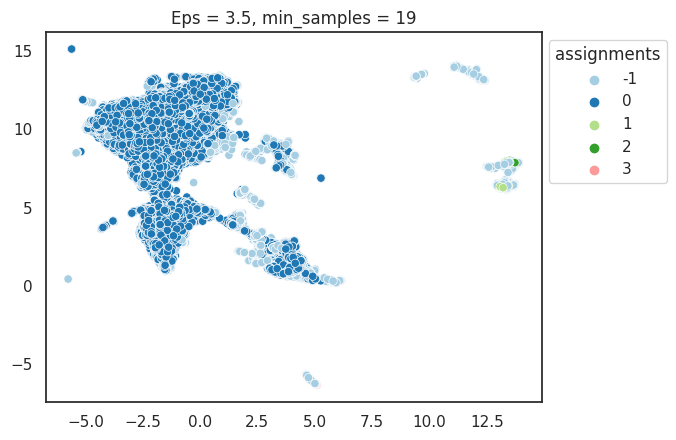

In [ ]:
#@title Plot Clusters onto UMAP
#handles = np.unique(labels)
sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='assignments', palette='Paired', marker='o')
ax.set_title('Eps = 3.5, min_samples = 19')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
#@title K-Means Clustering
#Here is the linear clustering algoritm. I've set the number of clusters to a few values that you can use for the model comparison,
#but you can change it to work better for you.
from sklearn.cluster import KMeans
scaled_clean_data_values_kmeans_2 = KMeans(n_clusters=2, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_2 = scaled_clean_data_values_kmeans_2.labels_
clean_data_values_db['kmc2_assignments'] = labels_2

scaled_clean_data_values_kmeans_4 = KMeans(n_clusters=4, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_4 = scaled_clean_data_values_kmeans_4.labels_
clean_data_values_db['kmc4_assignments'] = labels_4

scaled_clean_data_values_kmeans_6 = KMeans(n_clusters=6, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_6 = scaled_clean_data_values_kmeans_6.labels_
clean_data_values_db['kmc6_assignments'] = labels_6

scaled_clean_data_values_kmeans_8 = KMeans(n_clusters=8, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_8 = scaled_clean_data_values_kmeans_8.labels_
clean_data_values_db['kmc8_assignments'] = labels_8

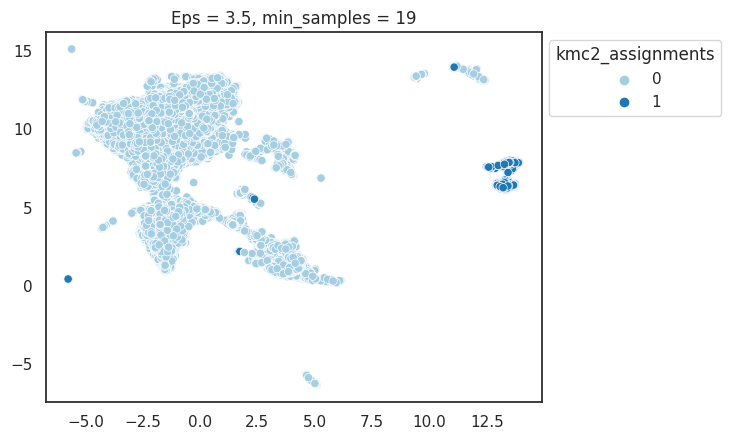

In [ ]:
#@title Plot with K-Means Cluster
sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='kmc2_assignments', palette='Paired', marker='o')
ax.set_title('Eps = 3.5, min_samples = 19')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

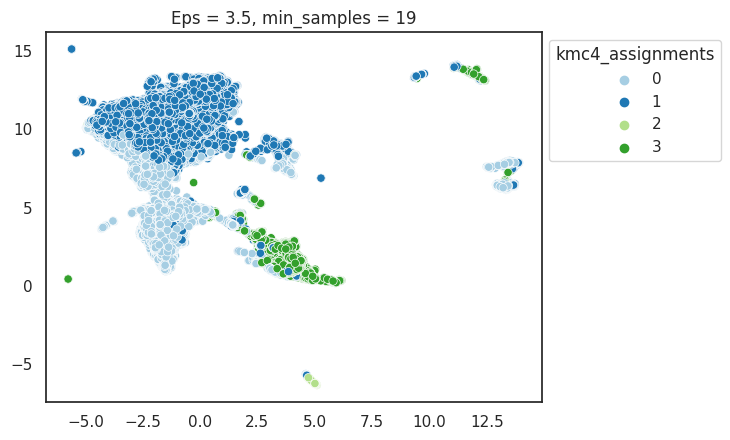

In [ ]:
#@title Plot with K-Means Cluster
sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='kmc4_assignments', palette='Paired', marker='o')
ax.set_title('Eps = 3.5, min_samples = 19')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

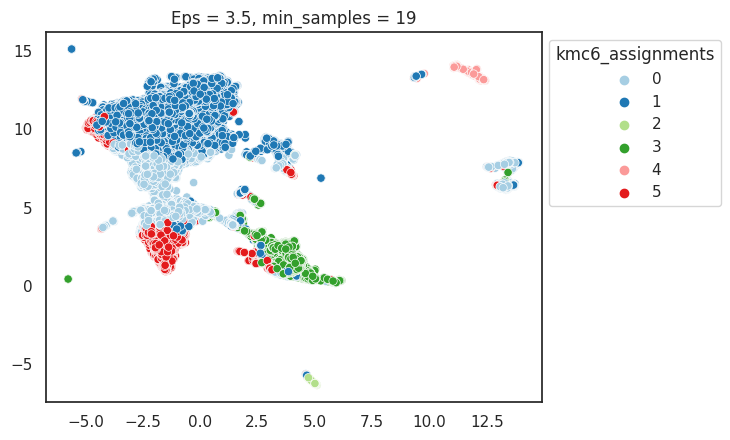

In [ ]:
#@title Plot with K-Means Cluster
sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='kmc6_assignments', palette='Paired', marker='o')
ax.set_title('Eps = 3.5, min_samples = 19')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#Part IV: Updated Dataframes with Cluster Membership

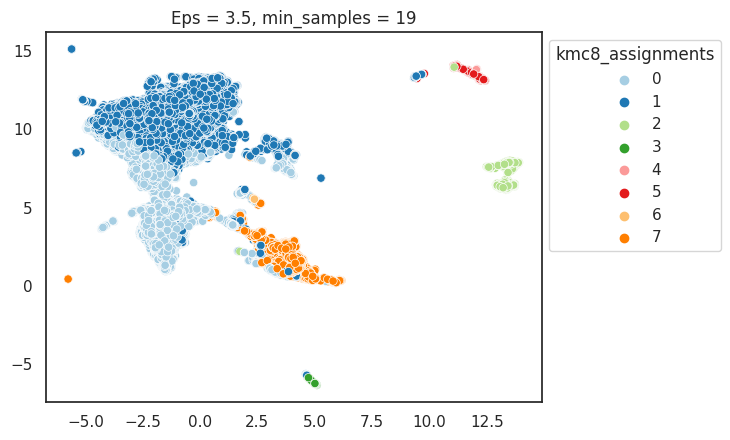

In [ ]:
#@title Plot with K-Means Cluster
sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='kmc8_assignments', palette='Paired', marker='o')
ax.set_title('Eps = 3.5, min_samples = 19')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
#@title Prepare Clean Data for Partitioning
clean_data_clustered = pd.concat([clean_data, clean_data_values_db['assignments']], axis=1)
clean_data_with_noise = clean_data_clustered
clean_data_clustered = clean_data_clustered.loc[clean_data_clustered.assignments >= 0]
clean_data_clustered = clean_data_clustered.drop(['strain_slug', 'region'], axis=1)
clean_data_clustered

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,...,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene,assignments
u_id,,,,,,,,,,,,,,,,,,,,,
0,0.934875,0.002195,0.051035,0.000000,0.0,0.011895,0.126627,0.005041,0.007724,0.005041,...,0.282619,0.080244,0.016521,0.089255,0.014919,0.057590,0.005041,0.161961,0.038028,0
1,0.942376,0.004544,0.047952,0.002478,0.0,0.002651,0.215732,0.005758,0.008682,0.012792,...,0.181566,0.073240,0.005758,0.115024,0.005758,0.040225,0.007331,0.210494,0.035078,0
2,0.942578,0.004096,0.047829,0.002907,0.0,0.002590,0.208189,0.006220,0.008142,0.016626,...,0.190361,0.069086,0.013722,0.110446,0.006220,0.036003,0.007452,0.209503,0.030722,0
3,0.966836,0.003003,0.025930,0.001726,0.0,0.002504,0.008019,0.008019,0.008019,0.000000,...,0.308981,0.108156,0.044945,0.295542,0.039173,0.028637,0.000000,0.000000,0.016085,0
4,0.934829,0.003692,0.049598,0.000000,0.0,0.011880,0.129744,0.008177,0.011458,0.008177,...,0.259848,0.094910,0.023999,0.081292,0.008177,0.068392,0.008177,0.147166,0.046147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88943,0.938651,0.002171,0.059177,0.000000,0.0,0.000000,0.000000,0.002157,0.000000,0.030630,...,0.290768,0.195427,0.060828,0.251079,0.029767,0.029336,0.000000,0.000000,0.017256,0
88944,0.950399,0.002075,0.047527,0.000000,0.0,0.000000,0.000000,0.006301,0.000000,0.020252,...,0.221872,0.257426,0.109811,0.207921,0.029253,0.044104,0.000000,0.008101,0.025653,0
88980,0.969916,0.002917,0.026502,0.000665,0.0,0.000000,0.059835,0.002063,0.000000,0.040578,...,0.191197,0.046080,0.020633,0.366575,0.038514,0.045392,0.000000,0.000000,0.097662,0


Text(0.5, 1.0, 'Cluster Profile Plot for Type I')

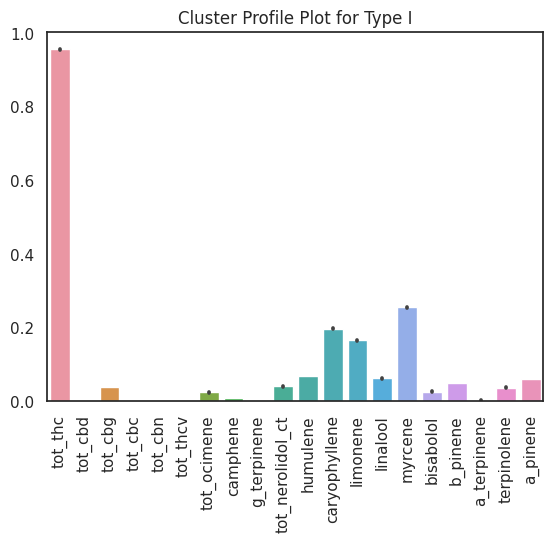

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_1 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 0]
Cluster_1 = Cluster_1.drop(columns='assignments')
sns.barplot(data=Cluster_1)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type I')

In [ ]:
#@title Cluster 1 Statistics
Cluster_1.loc['mean'] = Cluster_1.mean()
#Cluster_1.loc['mean']
Cluster_1.loc['std'] = Cluster_1.std()
Cluster_1.loc[['mean','std']]

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,
mean,0.955419,0.003185,0.037935,0.001017,0.000575,0.001869,0.024329,0.009784,0.002426,0.040421,0.068002,0.196367,0.165870,0.062414,0.254902,0.026367,0.049874,0.00213,0.036505,0.060607
std,0.021839,0.005376,0.020391,0.002191,0.001617,0.004201,0.043914,0.007972,0.005129,0.057738,0.041092,0.109001,0.109721,0.044944,0.172376,0.023339,0.028174,0.00533,0.096362,0.071199


In [ ]:
print(len(Cluster_1))

21201


In [ ]:
Cluster_1_max_terp = Cluster_1.iloc[:,6:]
Cluster_1_max_terp['max_terp'] = Cluster_1_max_terp.idxmax(axis=1)
Cluster_1_max_terp.head()

<ipython-input-72-daf943d531ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_1_max_terp['max_terp'] = Cluster_1_max_terp.idxmax(axis=1)


,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene,max_terp
u_id,,,,,,,,,,,,,,,
0,0.126627,0.005041,0.007724,0.005041,0.109391,0.282619,0.080244,0.016521,0.089255,0.014919,0.057590,0.005041,0.161961,0.038028,caryophyllene
1,0.215732,0.005758,0.008682,0.012792,0.082561,0.181566,0.073240,0.005758,0.115024,0.005758,0.040225,0.007331,0.210494,0.035078,tot_ocimene
2,0.208189,0.006220,0.008142,0.016626,0.087307,0.190361,0.069086,0.013722,0.110446,0.006220,0.036003,0.007452,0.209503,0.030722,terpinolene
3,0.008019,0.008019,0.008019,0.000000,0.134423,0.308981,0.108156,0.044945,0.295542,0.039173,0.028637,0.000000,0.000000,0.016085,caryophyllene
4,0.129744,0.008177,0.011458,0.008177,0.104336,0.259848,0.094910,0.023999,0.081292,0.008177,0.068392,0.008177,0.147166,0.046147,caryophyllene


In [ ]:
#ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=Cluster_1_max_terp, hue='max_terp', palette='tab20', marker='o')
#ax.set_title('Clusters')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Cluster Profile Plot for Type II')

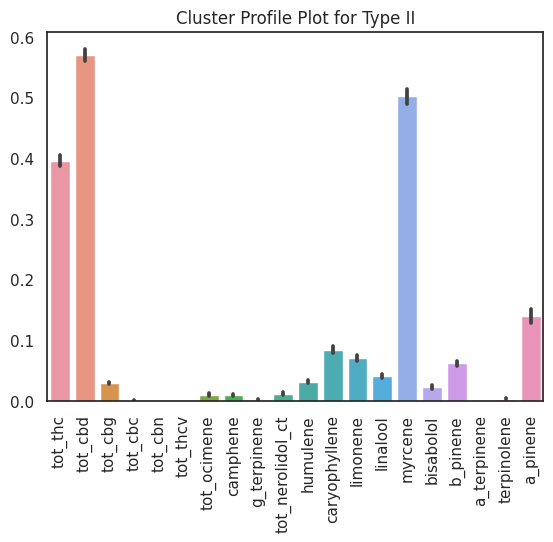

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_2 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 1]
Cluster_2 = Cluster_2.drop(columns='assignments')
sns.barplot(data=Cluster_2)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type II')

In [ ]:
#@title Cluster 2 Statistics
Cluster_2.loc['mean'] = Cluster_2.mean()
#Cluster_1.loc['mean']
Cluster_2.loc['std'] = Cluster_2.std()
Cluster_2.loc[['mean','std']]

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,
mean,0.396095,0.570469,0.030037,0.001116,0.000194,0.002089,0.010707,0.010065,0.002546,0.012618,0.031927,0.085044,0.071809,0.042079,0.502764,0.023563,0.062299,0.000557,0.004044,0.139978
std,0.060670,0.059980,0.014910,0.001754,0.000615,0.003504,0.016302,0.007543,0.004360,0.017695,0.017749,0.037029,0.028610,0.020843,0.084801,0.016948,0.021643,0.002136,0.006491,0.065216


In [ ]:
print(len(Cluster_2))

153


Text(0.5, 1.0, 'Cluster Profile Plot for Type III')

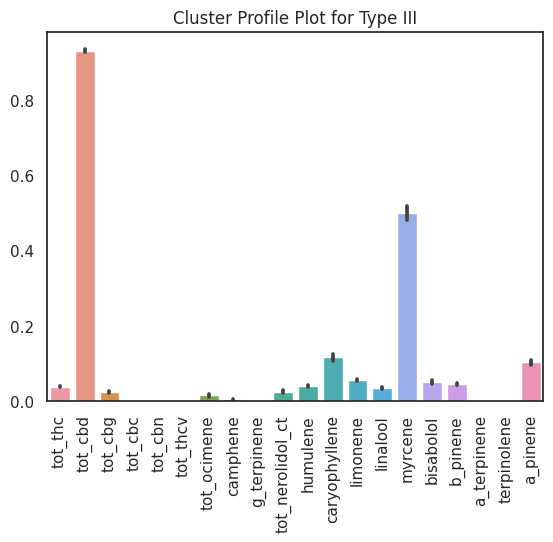

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_3 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 2]
Cluster_3 = Cluster_3.drop(columns='assignments')
sns.barplot(data=Cluster_3)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type III')

In [ ]:
#@title Cluster 3 Statistics
Cluster_3.loc['mean'] = Cluster_3.mean()
#Cluster_1.loc['mean']
Cluster_3.loc['std'] = Cluster_3.std()
Cluster_3.loc[['mean','std']]

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,
mean,0.039302,0.932037,0.025184,0.002921,0.000176,0.000379,0.015618,0.005625,0.000521,0.025035,0.040236,0.116852,0.055990,0.034660,0.500763,0.051542,0.045530,0.000635,0.003206,0.103788
std,0.011067,0.022185,0.018226,0.002715,0.000533,0.000916,0.021002,0.007684,0.002345,0.024970,0.021070,0.055515,0.019094,0.021561,0.110028,0.031396,0.016131,0.002774,0.006685,0.042367


In [ ]:
print(len(Cluster_3))

146


Text(0.5, 1.0, 'Cluster Profile Plot for Type IV')

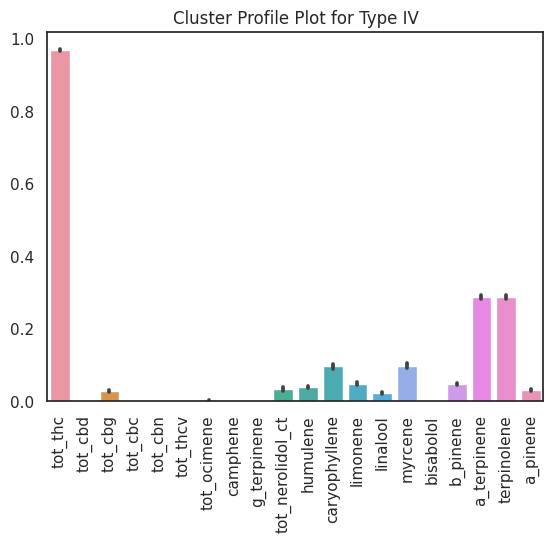

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_4 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 3]
Cluster_4 = Cluster_4.drop(columns='assignments')
sns.barplot(data=Cluster_4)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type IV')

In [ ]:
#@title Cluster 3 Statistics
Cluster_4.loc['mean'] = Cluster_4.mean()
#Cluster_1.loc['mean']
Cluster_4.loc['std'] = Cluster_4.std()
Cluster_4.loc[['mean','std']]

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,
mean,0.967765,0.001320,0.029577,0.000871,0.000358,0.000109,0.002311,0.000153,0.000863,0.034295,0.039884,0.096867,0.048409,0.023391,0.098386,0.0,0.048688,0.287359,0.287359,0.032036
std,0.017972,0.002532,0.017519,0.001988,0.001081,0.000659,0.011772,0.001324,0.002688,0.030904,0.018988,0.043506,0.026086,0.013804,0.045460,0.0,0.018598,0.038521,0.038521,0.015712


In [ ]:
print(len(Cluster_4))

154


Text(0.5, 1.0, 'Cluster Profile Plot for Type V')

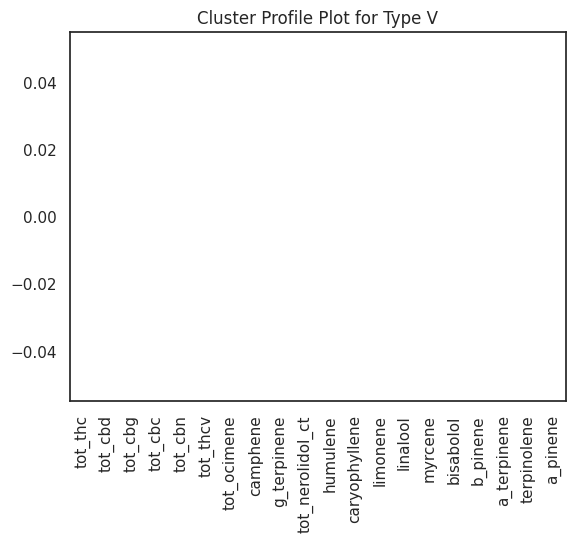

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_5 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 4]
Cluster_5 = Cluster_5.drop(columns='assignments')
sns.barplot(data=Cluster_5)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type V')

In [ ]:
#@title Cluster 5 Statistics
Cluster_5.loc['mean'] = Cluster_5.mean()
#Cluster_1.loc['mean']
Cluster_5.loc['std'] = Cluster_5.std()
Cluster_5.loc[['mean','std']]

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(len(Cluster_5))

2


Text(0.5, 1.0, 'Cluster Profile Plot for Outliers')

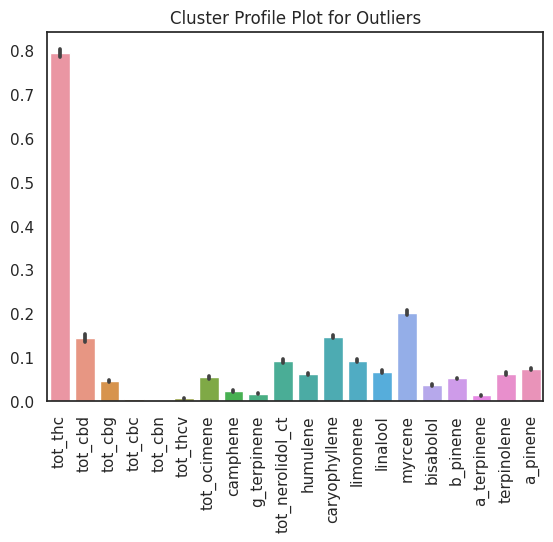

In [ ]:
#@title Create Cluster Subsets for Outlier Statistics
Outliers = clean_data_with_noise.loc[clean_data_with_noise['assignments'] == -1]
Outliers = Outliers.drop(columns=['strain_slug','region','assignments'])
sns.barplot(data=Outliers)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Outliers')

In [ ]:
#@title Cluster 3 Statistics
Outliers.loc['mean'] = Outliers.mean()
#Cluster_1.loc['mean']
Outliers.loc['std'] = Outliers.std()
Outliers.loc[['mean','std']]

,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
u_id,,,,,,,,,,,,,,,,,,,,
mean,0.794057,0.144817,0.046748,0.004688,0.003221,0.006469,0.054411,0.023144,0.017630,0.092243,0.061688,0.147757,0.092652,0.067563,0.202237,0.037283,0.052816,0.014044,0.063067,0.073464
std,0.299093,0.299268,0.060503,0.012645,0.006368,0.027513,0.098516,0.057351,0.052261,0.160599,0.073830,0.125992,0.109124,0.114183,0.170002,0.056784,0.048404,0.044636,0.122884,0.089803


In [ ]:
print(len(Outliers))

4389
